# Prosper Loan Data
## by Alejandro Rodriguez Martinez

## Preliminary Wrangling

> This dataset contains information on loans given to individuals. There are 113937 entries with 81 variables each. For this analysis only a subset of them will be chosen. Interesting variables include Borrower's APR, Loan Status or Credit score to name a few

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
from scipy.stats import norm
%matplotlib inline

Let's load the dataset and get an overview of the main properties for the data.

In [2]:
loan = pd.read_csv('prosperLoanData.csv')
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

There are a few columns that are IDs, these can be removed. IDs may be of use when joining different dataframes or when drawing conclusions for specific individuals. However this analysis is rather on the aggregated side. The idea is to find out relationship between variables in the data set as a whole and so IDs are of no use in this case. However before removing unique IDs, let's make sure there are no duplicates

In [3]:
listingkeyfilt= [i for i,j in loan.ListingKey.value_counts().iteritems() if j > 1]
len(listingkeyfilt)   # ProsperScore seems to be not reliable

827

It seems that there are many duplicates for column ListingKey. However when using pandas duplicated() method, pandas seems to suggest that there are no duplicates.


In [4]:
sum(loan.duplicated())

0

This leads me to think that there are columns that are different for the same ListingKey ID. Visual inspection in Excel reveals that **ProsperScore** column contains different numbers for what otherwise would be an duplicate entry. To me it doesn't make sense to allocate different risk scores to the same data. Therefore this column seems unreliable and it will be a column we will drop for our analysis.

In [5]:
loan_clean = loan.drop('ProsperScore',axis=1)
sum(loan_clean.ListingKey.duplicated())

871

It can be observed above that now there are 871 rows that are duplicated and thus can be removed. Let's do so

In [6]:
print(loan_clean.shape[0])
loan_clean.drop_duplicates(inplace=True)
print(loan_clean.shape[0])

113937
113066


Other column that show IDs are: ListingNumber, LoanKey, LoanNumber. Let's remove them

In [7]:
for colnametoDrop in ['ListingKey','ListingNumber', 'LoanKey', 'LoanNumber']:
    loan_clean.drop(colnametoDrop,axis=1,inplace=True)
loan_clean.shape

(113066, 76)

MemberKey and GroupKey columns are not unique, but we are not interested in particular customers, so these columns can be removed as well

In [8]:
loan_clean.drop(['MemberKey','GroupKey'],axis=1,inplace=True)
loan_clean.shape

(113066, 74)

There are some other columns that contain too many NaN values, when deciding which columns to analyse the ones that contain less information will be discarded. However since there are so many columns that need to be removed, it may be more sensible to select the subset of columns that we want to analyse.
For starters, let's narrow down the number of variables to 17 columns that we can group in the following manner. Please note that below there are two variables highlighted in blue. These are the dependent variables of interest in the following document   

**Numerical Discrete**
- 'EmploymentStatusDuration' 
- 'CreditScoreRangeUpper'
- 'DelinquenciesLast7Years'
- 'RevolvingCreditBalance'
- 'AvailableBankcardCredit'
- 'LoanOriginalAmount'  

**Numerical Continuous**
- <span style="color:blue">'BorrowerAPR'</span>
- 'LenderYield'
- 'DebtToIncomeRatio'

**Categorical/ Nominal**
- 'EmploymentStatus'    -  9 categories
- 'IsBorrowerHomeowner' - 2 categories
- <span style="color:blue">'LoanStatus'</span> - 12 categories    

**Ordinal**
- 'Term'
- 'IncomeRange'
- 'CreditGrade'                         
- 'ProsperRating (Alpha)'               

In [9]:
columnsToKeep = ['EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','LoanOriginalAmount','BorrowerAPR','LenderYield','DebtToIncomeRatio','EmploymentStatus','IsBorrowerHomeowner','LoanStatus','Term','IncomeRange','CreditGrade','ProsperRating (Alpha)']
loan_clean.drop([x for x in loan_clean.columns if x not in columnsToKeep],axis=1,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 28953 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
ProsperRating (Alpha)       83982 non-null object
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), float64(8), int64(2), object(5)
memory usage: 13.9+ MB

Interestingly, the two columns that contain fewer entries, namely Credit Grade and Prosper Rating, complement one another. It can be seen below that they both never contain values for the same entry and only a few entries are missing both variables. 

In [10]:
print('Both columns are null at the same time: {}'.format(sum(loan_clean['CreditGrade'].isna() & loan_clean['ProsperRating (Alpha)'].isna())))
print('Both columns are not null at the same time: {}'.format(sum(loan_clean['CreditGrade'].notna() & loan_clean['ProsperRating (Alpha)'].notna())))

Both columns are null at the same time: 131
Both columns are not null at the same time: 0


Therefore we can join both columns into one, let's keep the name credit grade

In [11]:
loan_clean['CreditGrade'].where(loan_clean['CreditGrade'].notna(),loan_clean['ProsperRating (Alpha)'],inplace=True)
loan_clean.drop('ProsperRating (Alpha)',axis=1,inplace=True)
print(loan_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 112935 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), float64(8), int64(2), object(4)
memory usage: 13.0+ MB
None


Both Ordinal and categorical/nominal data could be casted as CategoricalDType. In this way it's clearer which variables are categorical and which ones are not.

In [12]:
loan_clean.CreditGrade.value_counts()
ordinal_var_dict = {'CreditGrade': ['NC','HR','E','D','C','B','A','AA'],
                    'Term':[12,36,60],
                    'IncomeRange':['Not displayed','Not employed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 112935 non-null category
Term                        113066 non-null category
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null category
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 10.8+ MB


It seems that there are some missing entries for some columns. Let's inspect *AvailableBankcardCredit* for example. This will help us determine whether those entries are candidates to remove or on the other hand they follow an specified pattern. Let's display a slice of them

In [13]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].sample(20)

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount
50426,A,36,Completed,0.07680,0.0600,NaN,NaN,False,NaN,NaN,NaN,NaN,0.02349,Not displayed,3000
37555,HR,36,Chargedoff,0.25757,0.2450,Not available,NaN,False,499.0,3.0,NaN,NaN,0.04000,Not displayed,2501
75948,E,36,Chargedoff,0.30112,0.2550,Not available,NaN,False,559.0,17.0,NaN,NaN,0.24000,Not displayed,1750
12638,HR,36,Defaulted,0.30962,0.2450,Not available,NaN,True,499.0,25.0,NaN,NaN,0.12000,Not displayed,1000
80035,E,36,Completed,0.23748,0.2250,Not available,NaN,False,579.0,0.0,NaN,NaN,0.37000,Not displayed,2500
53141,C,36,Completed,0.17722,0.1650,Not available,NaN,False,679.0,35.0,NaN,NaN,0.16000,Not displayed,6000
37238,B,36,Defaulted,0.23748,0.2250,NaN,NaN,True,699.0,NaN,NaN,NaN,0.30000,Not displayed,12000
87056,AA,36,Completed,0.11696,0.1050,NaN,NaN,False,799.0,0.0,NaN,NaN,0.27000,Not displayed,4000
62609,C,36,Defaulted,0.15713,0.1450,Not available,NaN,True,659.0,0.0,NaN,NaN,0.14000,Not displayed,4000
18774,NC,36,Defaulted,0.28771,0.2625,NaN,NaN,False,19.0,0.0,NaN,NaN,0.04000,Not displayed,2500


In [14]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].Term.value_counts()

36    7544
60       0
12       0
Name: Term, dtype: int64

It seems that those entries that contain missing values for bankcard credit also contain missing values for some other columns. Also, it seems that it can be safe to rename NaN for Not available in **EmploymentStatus** column. Also notice that all entries that do not contain information for AvailableBankcardCredit correspond to loans on 36-month term... This is perhaps something to be wary about when drawing conclusions. However, for this analysis and bearing in mind that there are many more entries for 36-month loans that for any of the other two categories, then let's remove these rows.
Another thing to note is that CreditGrade already contains a NaN value which is NC


In [15]:
loan_clean.EmploymentStatus.replace(np.nan,'Not available',inplace=True)
loan_clean.CreditGrade.replace(np.nan,'NC',inplace=True)
loan_clean.drop(loan_clean[loan_clean.AvailableBankcardCredit.isna()].index,axis=0,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105439 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105500 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           97172 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 10.1+ MB


EmploymentStatusDuration, RevolvingCreditBalance, DeliquenciesLast7Years and DebtToIncomeRatio are likely to impact the CreditGrade... Since all entries have an associated CreditGrade let's fill the missing gaps with the average value for the creditgrade group

In [16]:
colToFil = ['EmploymentStatusDuration', 'RevolvingCreditBalance', 'DelinquenciesLast7Years','DebtToIncomeRatio']
for col in colToFil:
    dummyValues = loan_clean.groupby('CreditGrade').mean().reset_index()[['CreditGrade',col]]
    valuesOnGrade = loan_clean[loan_clean[col].isna()].merge(dummyValues,how='left',on='CreditGrade')['{}_y'.format(col)]
    indexesToWrite = loan_clean[loan_clean[col].isna()].index
    loan_clean.loc[indexesToWrite,col] = valuesOnGrade.values
    loan_clean[loan_clean[col].isna()]
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105522 non-null float64
RevolvingCreditBalance      105522 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 15.1+ MB


Now, there are no more missing entries. Discrete values can therefore be converted to int

In [17]:
loan_clean.EmploymentStatusDuration = loan_clean.EmploymentStatusDuration.astype('int64')
loan_clean.CreditScoreRangeUpper = loan_clean.CreditScoreRangeUpper.astype('int64')
loan_clean.DelinquenciesLast7Years = loan_clean.DelinquenciesLast7Years.astype('int64')
loan_clean.RevolvingCreditBalance = loan_clean.RevolvingCreditBalance.astype('int64')
loan_clean.AvailableBankcardCredit = loan_clean.AvailableBankcardCredit.astype('int64')
loan_clean.LoanOriginalAmount = loan_clean.LoanOriginalAmount.astype('int64')
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null int64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null int64
DelinquenciesLast7Years     105522 non-null int64
RevolvingCreditBalance      105522 non-null int64
AvailableBankcardCredit     105522 non-null int64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(3), int64(6), object(2)
memory usage: 15.1+ MB


Let's check for outliers now

In [18]:
loan_clean.describe()

,BorrowerAPR,LenderYield,EmploymentStatusDuration,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,LoanOriginalAmount
count,105522.000000,105522.000000,105522.000000,105522.000000,105522.000000,1.055220e+05,105522.000000,105522.000000,105522.000000
mean,0.220380,0.183041,96.058831,710.200508,3.928792,1.759210e+04,11208.182028,0.276848,8543.270702
std,0.081034,0.075078,94.395073,56.659748,9.800208,3.293661e+04,19847.681185,0.505246,6257.927037
min,0.006530,-0.010000,0.000000,19.000000,0.000000,0.000000e+00,0.000000,0.000000,1000.000000
25%,0.157130,0.123500,26.000000,679.000000,0.000000,3.102000e+03,876.000000,0.150000,4000.000000
50%,0.211150,0.173000,67.000000,699.000000,0.000000,8.538000e+03,4090.000000,0.230000,7000.000000
75%,0.285740,0.241100,137.000000,739.000000,3.000000,1.951950e+04,13165.000000,0.310000,12000.000000
max,0.423950,0.340000,755.000000,899.000000,99.000000,1.435667e+06,646285.000000,10.010000,35000.000000


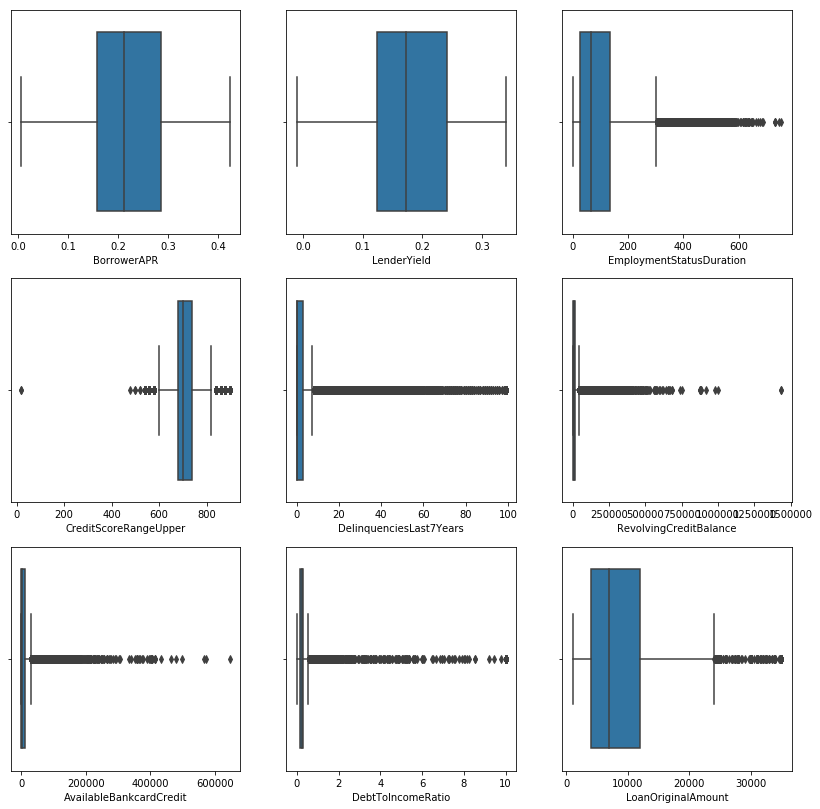

In [19]:
boxplotvarlist = ['BorrowerAPR','LenderYield','EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount']
plt.figure(figsize=[14,14]);
for i,var in enumerate(boxplotvarlist):
    plt.subplot(3,3,i+1)
    sb.boxplot(data=loan_clean, x=var)

From the graph above it can be seen that some variables are really skewed, others are more evenly distributed. There is one though that seems to contain wrong values. **CreditScoreRangeUpper** seems to have unsually low values that I need to inspect. The other variables look somehow normal to me, so I will not inspect them further to look for outliers

In [20]:
loan_clean[loan_clean.CreditScoreRangeUpper < 250]

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount
794,NC,36,Completed,0.29776,0.285,Not available,74,False,19,2,12039,0,0.25,Not displayed,4000
109468,NC,36,Completed,0.12700,0.105,Not available,74,False,19,2,12039,0,0.25,Not displayed,2550


This inspection shows that most parameters have been filled in with mean values as the originals were probably missing. The fact that CreditScoreRangeUpper contains doggy values suggests that perhaps the whole entry is not reliable. Let's remove these two entries from the cleaned dataset

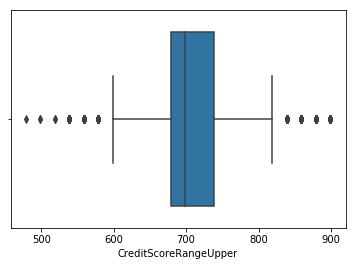

In [21]:
loan_clean.drop(loan_clean[loan_clean.CreditScoreRangeUpper < 250].index,axis=0,inplace=True)
sb.boxplot(data=loan_clean, x='CreditScoreRangeUpper');

Let's see what happens with non-numerical variables

In [22]:
loan_clean.describe(exclude = np.number)

,CreditGrade,Term,LoanStatus,EmploymentStatus,IsBorrowerHomeowner,IncomeRange
count,105520,105520,105520,105520,105520,105520
unique,8,3,12,8,2,8
top,C,36,Current,Employed,True,"$25,000-49,999"
freq,22642,79678,55730,66598,54523,31940


In [23]:
loan_clean.shape

(105520, 15)

There is nothing relevante on this front...
**Data wrangling has been completed** and now we have a clean data set to work with. In this data set there is a good mix of all data types seen throughout the course. As described before there are discrete and continuous values as well as ordinal and categorical data.

### What is the structure of your dataset?

> The cleaned data set contains 105,520 loans with 16 features for each loan. The features are a mix of numerical values, both continuous and discrete as well as categorical and ordinal variables.

### What is/are the main feature(s) of interest in your dataset?

> There are two variables that we are mostly concerned with, these are BorrowerAPR and LoanStatus. Analysing these will help us answer the following two questions    
1 - How can a client of a financial institution get a better deal when applying for a loan?    
2 - How can a financial institution predict which clients are more likely to default on a loan?


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> As listed above, we start with 14 features I think will help answer the two questions above. The idea is to find which of these features have the greatest impact on the two dependent variables. Along this document some of these features may be dropped or further investigated depending on whether it can be visually observed their relation with BorrowerAPR and LoanStatus

Let's start analysing the variables individually, to better understand their distributions and assess whether further cleaning is possible.

## Univariate Exploration

> Let's start with dependent variables. In this case BorrowerAPR. Let's analyse the variable on its own first before comparing it with others

In [24]:
loan_clean.BorrowerAPR.describe()

count    105520.000000
mean          0.220380
std           0.081034
min           0.006530
25%           0.157130
50%           0.211150
75%           0.285740
max           0.423950
Name: BorrowerAPR, dtype: float64

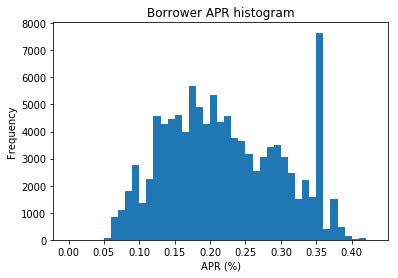

In [25]:
binsize = 0.01
binedges = np.arange(0,0.43+binsize,binsize)
plt.hist(loan_clean['BorrowerAPR'],bins=binedges);
plt.xticks(np.arange(0,0.45,0.05));
plt.title('Borrower APR histogram');
plt.xlabel('APR (%)');
plt.ylabel('Frequency');

The histogram above shows a somewhat right skewed distribution with a suprising spike at around 0.35 - 0.36 % interest. Let's inspect the data frame to check if we can see any pattern

In [26]:
loan_clean[(loan_clean['BorrowerAPR'] >= 0.35) & (loan_clean['BorrowerAPR'] < 0.36)].CreditGrade.value_counts()

HR    5284
E     2264
D       64
C       32
A        4
B        2
NC       2
AA       0
Name: CreditGrade, dtype: int64

Based on the ratings above, it seems that the algorithm that calculates the APR seems to be giving an interest rate of around 0.35 for all those customers with bad credit ratings.

Let's move now to analyze LoanStatus dependent variable.

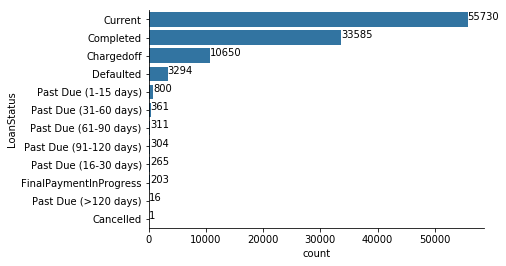

In [27]:
basecolor = sb.color_palette()[0]
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value,i,value)

It seems that *Past Due (...)* does not give much information as numbers are relatively low compared to other categories. In principle all Past Due subcategories refer to the fact that payment is late. If this category was to be analysed on its own, perhaps it wouldn't make much sense to join all of them. However, since this is not the case and all of them suggest that the borrower is late on the payment, let's join all of them into one category. In this way the dataframe will be cleaner. Also note that there is only one entry for *Cancelled*. One entry alone will most likely not be representative of the whole category and the analysis may be enhanced if that entry gets removed

In [28]:
loan_clean.LoanStatus.value_counts()

Current                   55730
Completed                 33585
Chargedoff                10650
Defaulted                  3294
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

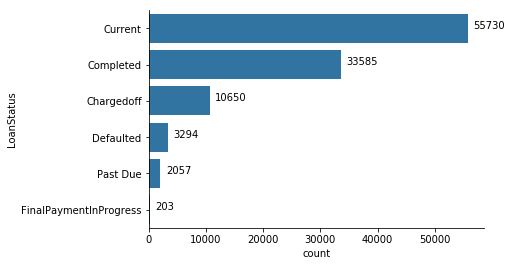

In [29]:
loan_clean.LoanStatus.replace(r'Past Due .+','Past Due',regex=True,inplace=True)
loan_clean.drop( loan_clean[loan_clean['LoanStatus'] == 'Cancelled'].index,axis=0,inplace=True)
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value+1000,i,value)

Let's analyse now the independent variables, starting with the categorical and ordinal ones.

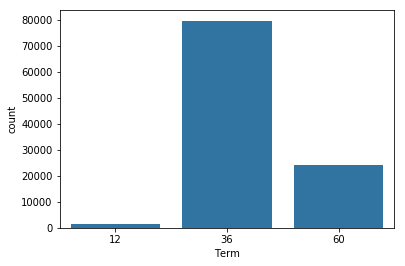

In [30]:
sb.countplot(data=loan_clean,x='Term',color=basecolor);

It can be seen above that 12-month loans are very unfrequent. Also, loans on 36 months are four times more frequent than those of 60. In order to simply the analysis let's keep only those loans with length 36 months as they seem to make the bulk of the analysis.

In [31]:
loan_clean.drop(loan_clean[loan_clean['Term'].isin([12,60])].index,axis=0,inplace=True)
loan_clean.drop('Term',axis=1,inplace=True)
loan_clean.columns

Index(['CreditGrade', 'LoanStatus', 'BorrowerAPR', 'LenderYield',
       'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CreditScoreRangeUpper', 'DelinquenciesLast7Years',
       'RevolvingCreditBalance', 'AvailableBankcardCredit',
       'DebtToIncomeRatio', 'IncomeRange', 'LoanOriginalAmount'],
      dtype='object')

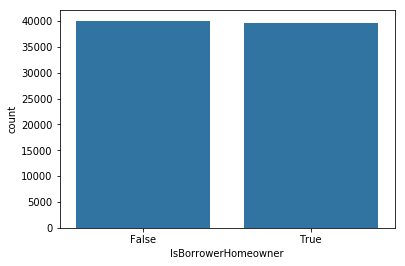

In [32]:
basecolor = sb.color_palette()[0]
sb.countplot(data=loan_clean, x='IsBorrowerHomeowner',color=basecolor)

The plot above clearly states that there number of loans is equally given to homeowners and no homeowners

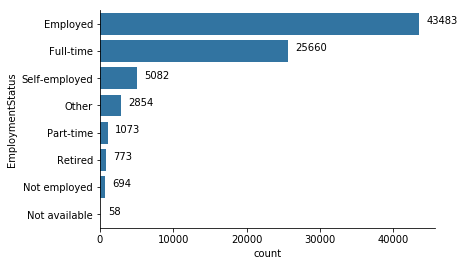

In [33]:
nameorder = loan_clean.EmploymentStatus.value_counts().index
namevalue = loan_clean.EmploymentStatus.value_counts().values
sb.countplot(data=loan_clean,y='EmploymentStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value+1000,i,value)

To me, the entry *Employed* results in information loss. The reason being that this category could be further broken down into either full-time or part-time. Also some categories have significantly smaller numbers than others. For example the number of retired people that got a loan in this data set is far smaller than people who are employed. Is this the true proportion of loans in reality or it's simply that retired people are not properly represented. Since I don't have a background on this topic and categories are misleading to me. Let's remove this variable altogether from the analysis. Also it makes sense to remove the numerical variable EmploymentStatusDuration since they are both related

In [34]:
loan_clean.drop(['EmploymentStatus','EmploymentStatusDuration'],axis=1,inplace=True)
loan_clean.columns

Index(['CreditGrade', 'LoanStatus', 'BorrowerAPR', 'LenderYield',
       'IsBorrowerHomeowner', 'CreditScoreRangeUpper',
       'DelinquenciesLast7Years', 'RevolvingCreditBalance',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'LoanOriginalAmount'],
      dtype='object')

Let's proceed now with variable IncomeRange

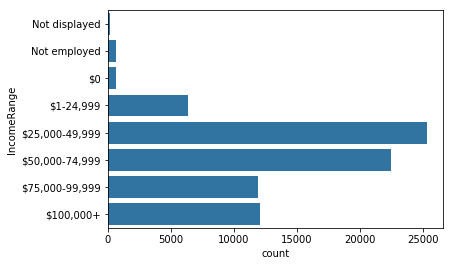

In [35]:
sb.countplot(data=loan_clean,y='IncomeRange',color=basecolor);

We can see above that most people getting loans have incomes between 25k and 75k dollars. There are very few loans given to Not Employed people. Also very few are given to people that do not earn anything. Let's remove these marginal categories to ease the analysis and plots. Results won't be affected since the bulk majority of data will still be present after the cleaning process

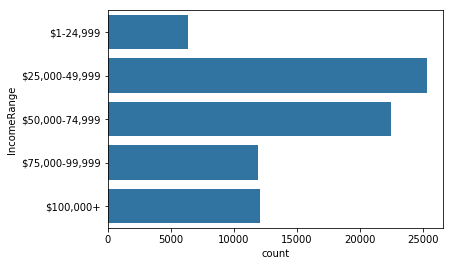

In [36]:
loan_clean.drop(loan_clean[loan_clean['IncomeRange'].isin(['Not displayed','Not employed','$0'])].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'IncomeRange':['$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
        
sb.countplot(data=loan_clean,y='IncomeRange',color=basecolor);

Lastly, let's analyse the CreditGrade variable.

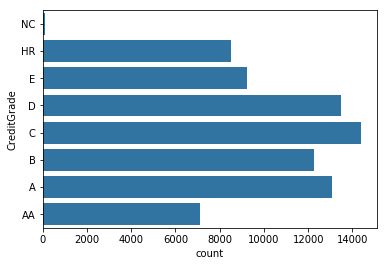

In [37]:
sb.countplot(data=loan_clean,y='CreditGrade',color=basecolor)

Again, it seems that NC does not add any value to the analysis. So let's remove it and make the data frame cleaner

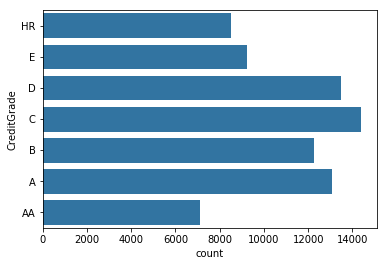

In [38]:
loan_clean.drop(loan_clean[loan_clean['CreditGrade'] == 'NC'].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'CreditGrade':['HR','E','D','C','B','A','AA']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
        
sb.countplot(data=loan_clean,y='CreditGrade',color=basecolor);

Let's now analyse the numerical independent variables starting with CreditScoreRangeUpper

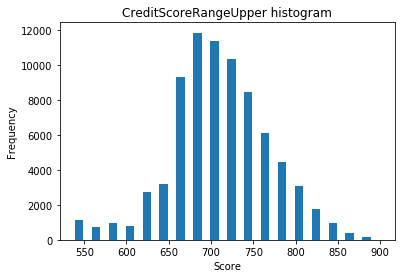

In [39]:
binsize = 10
binedges = np.arange(loan_clean['CreditScoreRangeUpper'].min(),loan_clean['CreditScoreRangeUpper'].max()+binsize,binsize)
plt.hist(loan_clean['CreditScoreRangeUpper'],bins=binedges);
plt.title('CreditScoreRangeUpper histogram');
plt.xlabel('Score');
plt.ylabel('Frequency');

Interestingly, it seems that credit score is given in steps of 20 starting from 9... Not sure what the reason for this is but it seems clear given the histogram above. Also the distribution seems to be normally distributed to the right but falls sharply on the left of the otherwise bell-curve. Let's use bins of 20, as this seems to be the pattern used by banks

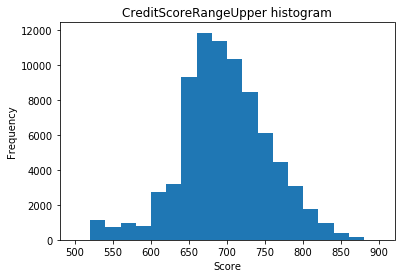

In [40]:
binsize = 20
binedges = np.arange(500,900+binsize,binsize)
plt.hist(loan_clean['CreditScoreRangeUpper'],bins=binedges);
plt.title('CreditScoreRangeUpper histogram');
plt.xlabel('Score');
plt.ylabel('Frequency');

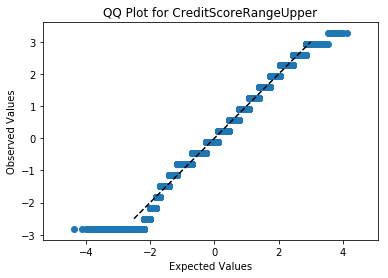

In [41]:
samp_mean = loan_clean['CreditScoreRangeUpper'].mean()
samp_sd = loan_clean['CreditScoreRangeUpper'].std()
n_points = loan_clean.shape[0]
qs = (np.arange(n_points) - .5) / n_points
expected_vals = norm.ppf(qs)
plt.scatter(expected_vals, (loan_clean['CreditScoreRangeUpper'].sort_values()-samp_mean)/samp_sd)
plt.plot([-2.5,3],[-2.5,3],'--', color = 'black')
plt.axis('equal')
plt.xlabel('Expected Values');
plt.ylabel('Observed Values');
plt.title('QQ Plot for CreditScoreRangeUpper');

The Q-Q plot above indicates what was postulated above. That is, data seems to be normally distributed on the right side of the centre, but this does not hold for the left side.
Let's now look at Delinquencies for the last 7 years

In [42]:
loan_clean['DelinquenciesLast7Years'].describe()

count    78069.000000
mean         4.143706
std         10.044423
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         99.000000
Name: DelinquenciesLast7Years, dtype: float64

Since the vast majority of deliquencies corresponds to no deliquencies, let's skip the value 0 to visualize the distribution

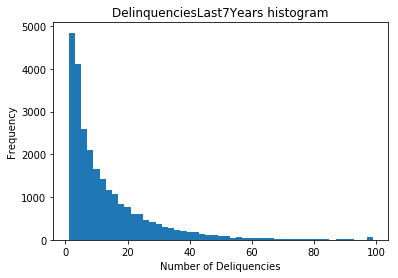

In [43]:
binsize = 2
binedges = np.arange(1,loan_clean['DelinquenciesLast7Years'].max()+binsize,binsize)
plt.hist(loan_clean['DelinquenciesLast7Years'],bins=binedges);
plt.title('DelinquenciesLast7Years histogram');
plt.xlabel('Number of Deliquencies');
plt.ylabel('Frequency');

The distribution above is extremely skewed to the right. Looking like an exponential distribution we can try using a logarithmic transformation to see if the transformed distribution approaches a normal distribution

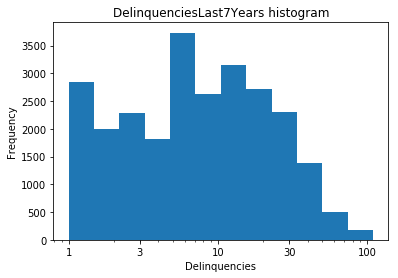

In [44]:
binsize = 0.17
binedges = 10**np.arange(0,np.log10(99)+binsize,binsize);
plt.hist(loan_clean['DelinquenciesLast7Years'],bins=binedges);
plt.title('DelinquenciesLast7Years histogram');
plt.xscale('log')
tick_locs = [1, 3, 10, 30, 100]
plt.xticks(tick_locs,tick_locs)
plt.xlabel('Delinquencies');
plt.ylabel('Frequency');

It seems that the transformed distribution does not show any signs of normality... We can then regard this variable to behave as an exponential distribution even though we have not performed any test to corroborate this hypothesis.
Let's see what happens with variable RevolvingCreditBalance

In [45]:
loan_clean['RevolvingCreditBalance'].describe()

count    7.806900e+04
mean     1.722816e+04
std      3.372062e+04
min      0.000000e+00
25%      2.696000e+03
50%      7.887000e+03
75%      1.862000e+04
max      1.435667e+06
Name: RevolvingCreditBalance, dtype: float64

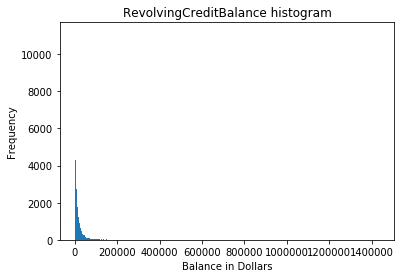

In [46]:
binsize = 1000
binedges = np.arange(0,loan_clean['RevolvingCreditBalance'].max()+binsize,binsize)
res = plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xlabel('Balance in Dollars');
plt.ylabel('Frequency');

It can be seen that the above distribution is extremely right skewed with possibly some outliers. Let's zoom in the range 0-100K and see what the distribution looks like

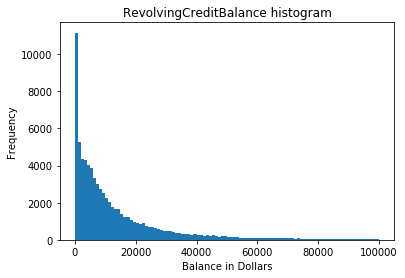

In [47]:
binsize = 1000
binedges = np.arange(0,100000+binsize,binsize)
res = plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xlabel('Balance in Dollars');
plt.ylabel('Frequency');

Very similar to an exponential distribution with perhaps the peculiarity that 0 seems to be the most common value. Let's apply some log transformation to see what the resulting data looks like

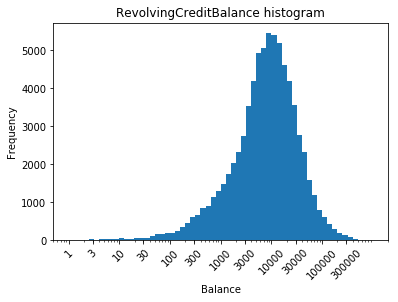

In [48]:
binsize = 0.1
binedges = 10**np.arange(0,np.log10(1000000)+binsize,binsize);
plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xscale('log');
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Balance');
plt.ylabel('Frequency');

It seems that Revolving Credit Balances is log normally distributed with a slight skew to the left.    

As it can be seen below data from variable AvailableBankcardCredit, the distribution shown is very similar to Revolving Credit Balance

(0, 100000)

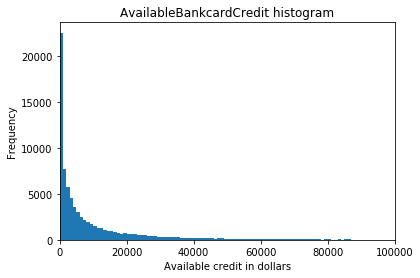

In [49]:
binsize = 1000
binedges = np.arange(0,loan_clean['AvailableBankcardCredit'].max()+binsize,binsize)
plt.hist(loan_clean['AvailableBankcardCredit'],bins=binedges);
plt.title('AvailableBankcardCredit histogram');
plt.xlabel('Available credit in dollars');
plt.ylabel('Frequency');
plt.xlim((0,100000))

Now, tranforming the data

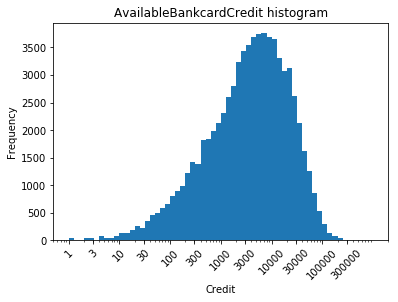

In [50]:
binsize = 0.1
binedges = 10**np.arange(0,np.log10(1000000)+binsize,binsize);
plt.hist(loan_clean['AvailableBankcardCredit'],bins=binedges);
plt.title('AvailableBankcardCredit histogram');
plt.xscale('log');
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

As expected the transformed data follows a similar distribution as the one seen for the previous variable. It's somewhat normally distributed with a skew to the left.

Let's now look at LoanOriginalAmount. Let's make the bin size small to find out whether there are standard loans or loans that are more often asked for

In [51]:
loan_clean['LoanOriginalAmount'].describe()

count    78069.000000
mean      7494.846046
std       5784.288003
min       1000.000000
25%       3500.000000
50%       5000.000000
75%      10000.000000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

(0, 40000)

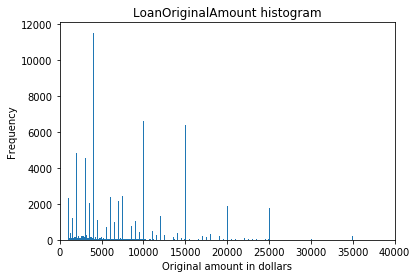

In [52]:
binsize = 100
binedges = np.arange(0,loan_clean['LoanOriginalAmount'].max()+binsize,binsize)
histRet=plt.hist(loan_clean['LoanOriginalAmount'],bins=binedges);
plt.title('LoanOriginalAmount histogram');
plt.xlabel('Original amount in dollars');
plt.ylabel('Frequency');
plt.xlim((0,40000))

Below we can see which are the most common loan amounts asked for. This is inline with the spikes in the graph above

In [53]:
freqVal =[i for i in zip(histRet[0],histRet[1])]
[i[1] for i in sorted(freqVal,reverse=True)[0:10]]

[4000, 10000, 15000, 5000, 2000, 3000, 2500, 7500, 6000, 1000]

When analysing LendeYield I expect to find a very similar data distribution as the one found for BorrowerAPR. The reason is that the Lender will try to assign the same Risk-Reward strategy. Let's see what happens

In [54]:
loan_clean['LenderYield'].describe()

count    78069.000000
mean         0.183511
std          0.079765
min         -0.010000
25%          0.117000
50%          0.170000
75%          0.249900
max          0.340000
Name: LenderYield, dtype: float64

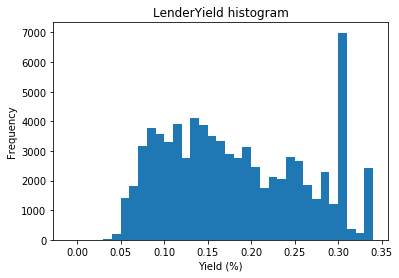

In [55]:
binsize = 0.01
binedges = np.arange(loan_clean['LenderYield'].min(),loan_clean['LenderYield'].max()+binsize,binsize)
plt.hist(loan_clean['LenderYield'],bins=binedges);
plt.title('LenderYield histogram');
plt.xlabel('Yield (%)');
plt.ylabel('Frequency');

The plot above confirms the hypothesis laid above. Lastly, let's look at variable DebtToIncomeRatio

In [56]:
loan_clean['DebtToIncomeRatio'].describe()

count    78069.000000
mean         0.278603
std          0.524644
min          0.000000
25%          0.150000
50%          0.230000
75%          0.320000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

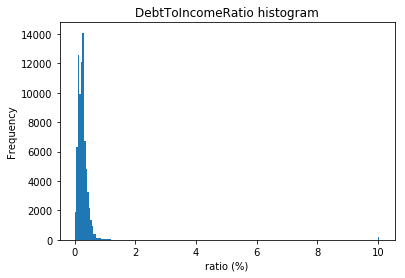

In [57]:
binsize = 0.05
binedges = np.arange(0,loan_clean['DebtToIncomeRatio'].max()+binsize,binsize)
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xlabel('ratio (%)');
plt.ylabel('Frequency');

It can be observed that the vast majority of data points is confined between 0 and 1. The fact that the axis go up to 10 indicate clear outliers. Let's perform a logarithmic transformation to find out more about the distribution

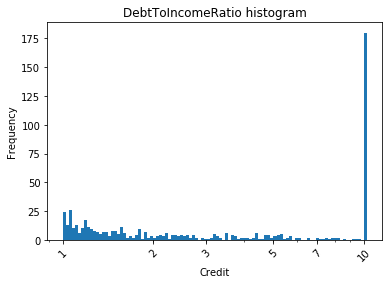

In [58]:
binsize = 0.01
binedges = 10**np.arange(0,np.log10(10.01)+binsize,binsize);
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xscale('log');
tick_locs = [1, 2, 3, 5, 7, 10]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

In [59]:
loan_clean[loan_clean['DebtToIncomeRatio'] > 10].sample(10)

,CreditGrade,LoanStatus,BorrowerAPR,LenderYield,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount
52890,AA,Completed,0.08634,0.0745,True,859,0,9212,110173,10.01,"$1-24,999",25000
84621,HR,Chargedoff,0.35643,0.3099,True,679,72,30999,17334,10.01,"$1-24,999",4000
19643,AA,Completed,0.16717,0.1475,False,779,0,20033,49867,10.01,"$1-24,999",9999
28608,AA,Chargedoff,0.13453,0.1150,True,779,9,392,237,10.01,"$1-24,999",5000
46841,A,Completed,0.16978,0.1526,False,739,0,11347,10332,10.01,"$1-24,999",15000
103610,A,Chargedoff,0.12223,0.1035,True,759,0,124159,11971,10.01,"$1-24,999",1275
88256,B,Completed,0.13393,0.1069,False,699,0,245,0,10.01,"$1-24,999",3500
36277,D,Defaulted,0.22693,0.1995,False,619,0,27412,8620,10.01,"$1-24,999",10500
4827,AA,Completed,0.08971,0.0625,False,819,0,5844,71156,10.01,"$1-24,999",1000
80832,B,Chargedoff,0.19228,0.1750,False,719,3,7,1102,10.01,"$1-24,999",6000


Not really sure how to interpret this, but the scaled plot shows an interesting fact. There are many people with a debt to income ratio of 10.01. Given the log distribution above it seems very unlikely that all these people share the same ratio... To me this looks like the ratio has been clipped on the top. The fact that it's clipped provides uncertainty about the real distribution, this is actually an information loss. I think the safest will be to remove these entries as they look bogus at least on one variable

In [60]:
loan_clean.drop(loan_clean[loan_clean['DebtToIncomeRatio'] > 10].index,axis=0,inplace=True)

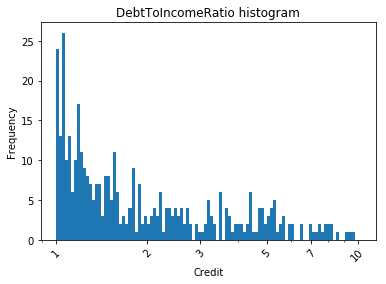

In [61]:
binsize = 0.01
binedges = 10**np.arange(0,np.log10(10.01)+binsize,binsize);
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xscale('log');
tick_locs = [1, 2, 3, 5, 7, 10]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> BorrowersAPR shows a somewhat normal distribution with a slight skew to the right. There is a spike of interest around 35% suggesting that bank's perceived risk for a big number of loans is the same. The other dependent variable LoanStatus, we've seen that some of its categories were very scarcely populated and so I decided to combine a few of them into one to make that category more relevant.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> From the categorical/ordinal features analysed, one of them was removed as it was deemed that its categories were not relevant enough for the analysis. Credit grade and Income Range were cleaned after visual inspection. Employment status was also removed as the quality of the data was poor and hard to interpret. As far as the numerical features are concerned. There was a few interesting aspects to note. For example, after visual inspection it was observed that DebtToIncomeRation had to be cleaned. Also, transforming logarithmically some distributions seemed to give a more normally looking distribution. However this transformation was not successful for every feature that was transformed. Making the bin size small, gave good results with feature LoanOriginalAmount and revealed a few spikes that showcase the most common loan amounts. Lastly, the Q-Q analysis in feature CreditScoreRangeUpper showed that this feature shows normality for the right side of the bell curve and not quite normal for the left side.

## Bivariate Exploration

> So now we are in a position to look at relationships between our variables of interest and the other features in a bivariate fashion. The idea is to find out which of the features are most important to define our dependent variables

In [62]:
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77889 entries, 0 to 113936
Data columns (total 12 columns):
CreditGrade                77889 non-null category
LoanStatus                 77889 non-null object
BorrowerAPR                77889 non-null float64
LenderYield                77889 non-null float64
IsBorrowerHomeowner        77889 non-null bool
CreditScoreRangeUpper      77889 non-null int64
DelinquenciesLast7Years    77889 non-null int64
RevolvingCreditBalance     77889 non-null int64
AvailableBankcardCredit    77889 non-null int64
DebtToIncomeRatio          77889 non-null float64
IncomeRange                77889 non-null category
LoanOriginalAmount         77889 non-null int64
dtypes: bool(1), category(2), float64(3), int64(5), object(1)
memory usage: 6.2+ MB


First look at the features that did not require any transformation and look at relationships of these and our variable of interest **BorrowerAPR**. Note that due to the sheer number of points a low value of alpha has to be applied to reveal relationships between these variables

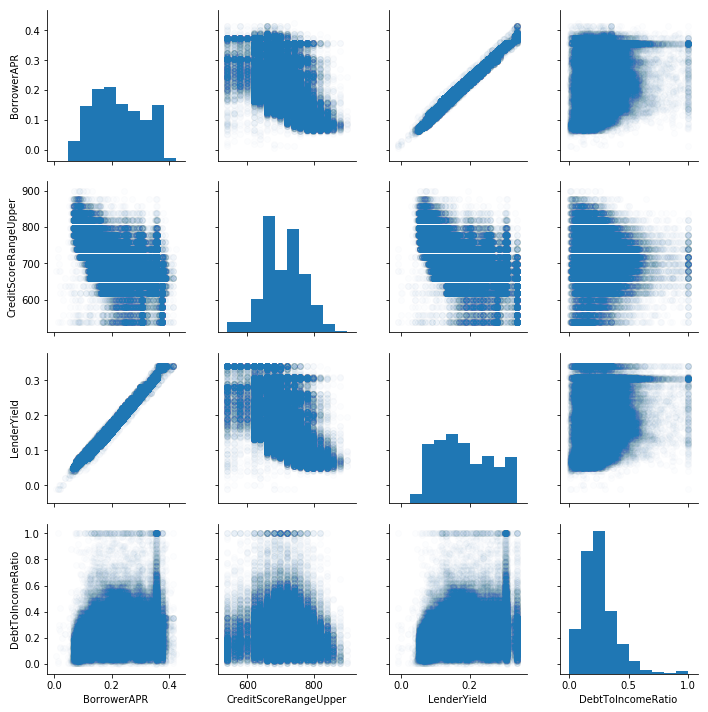

In [63]:
varsToScatter = loan_clean[['BorrowerAPR','CreditScoreRangeUpper','LenderYield','DebtToIncomeRatio']].copy()
varsToScatter['DebtToIncomeRatio'] = varsToScatter['DebtToIncomeRatio'].where(lambda x: x < 1, 1)
g = sb.PairGrid(data=varsToScatter, vars = ['BorrowerAPR','CreditScoreRangeUpper','LenderYield','DebtToIncomeRatio'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, alpha=0.01)

The following variables have displayed massive skewness in their distribution and as such we will be applying clipping to their data. Otherwise the scatterplots are too squashed to one side and it's harder to appreciate any relation between variables.   

Above it can be seen that BorrowerAPR has a clear positive correlation with LenderYield. This was anticipated in the univariate analysis and it's confirmed with the plot above. The relationship between BorrowerAPR and CreditScoreRangeUpper is not as clear cut and I had to play with the parameter alpha in order to get a snapshot where the relationship was displayed. It shows a somewhat negative correlation. This means that people with better credit scores generally get better APR. In principle I would have thought that this relationship would be easier to observe, but it seems that APR is calculated based on many parameters being this one only one of them. Later on in this document we will plot this relation with a heatmap to see if that becomes clearer.

Now, let's check what happens with those features that requires some kind of transformation due to their long tails. As far as the scatterplot let's clip their values to a maximum, so the plot does not get too squashed.

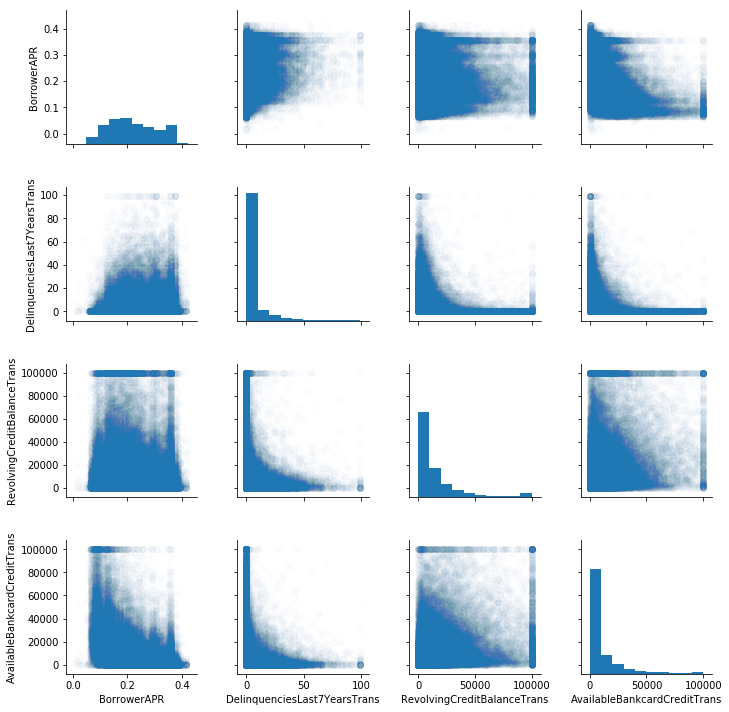

In [64]:
# Clip the variables as they are highly skewed
varsToScatter['DelinquenciesLast7YearsTrans'] = loan_clean['DelinquenciesLast7Years'].where(lambda x: x < 100, 100)
varsToScatter['RevolvingCreditBalanceTrans'] = loan_clean['RevolvingCreditBalance'].where(lambda x: x < 100000, 100000)
varsToScatter['AvailableBankcardCreditTrans'] = loan_clean['AvailableBankcardCredit'].where(lambda x: x < 100000, 100000)
g = sb.PairGrid(data=varsToScatter, vars = ['BorrowerAPR','DelinquenciesLast7YearsTrans','RevolvingCreditBalanceTrans','AvailableBankcardCreditTrans'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter,alpha=0.01)

A few interesting relationships can be observed. Note that the variable of interest is BorrowerAPR and it shows some degree of correlation with the other features, however this to me looks weaker than the previous ones. It is clear from the graph above that the number of delinquencies impacts the starting BorrowerAPR. The more delinquencies the higher the APR is. This makes sense as more delinquencies will indicate that the person requesting the loan may pose more risk to the bank. However since the number of delinquencies is not the only factor to take into account, then it means that the upper range is not limited by this feature.     
The other two relationships are less clear, at least with a scatterplot. It can be hinted from the plot above that the more the revolving creadit or available bank card credit, the better rate a person gets. However this relation is hard to see. I suspect that correlation values are weaker in this case.

In [65]:
varsToScatter.corr()

,BorrowerAPR,CreditScoreRangeUpper,LenderYield,DebtToIncomeRatio,DelinquenciesLast7YearsTrans,RevolvingCreditBalanceTrans,AvailableBankcardCreditTrans
BorrowerAPR,1.000000,-0.487100,0.993255,0.198761,0.168584,-0.079070,-0.400584
CreditScoreRangeUpper,-0.487100,1.000000,-0.498560,-0.032018,-0.243733,0.127265,0.510716
LenderYield,0.993255,-0.498560,1.000000,0.193529,0.171437,-0.084488,-0.391451
DebtToIncomeRatio,0.198761,-0.032018,0.193529,1.000000,-0.138237,0.191510,-0.000638
DelinquenciesLast7YearsTrans,0.168584,-0.243733,0.171437,-0.138237,1.000000,-0.179148,-0.156770
RevolvingCreditBalanceTrans,-0.079070,0.127265,-0.084488,0.191510,-0.179148,1.000000,0.304996
AvailableBankcardCreditTrans,-0.400584,0.510716,-0.391451,-0.000638,-0.156770,0.304996,1.000000


The calculated cross correlation table above, indicates what has been mentioned above. The strong correlation with LenderYield. Also the negative correlation with CreditScoreRangeUpper. Surprisingly, at least to me, the correlation score for AvailableBankcardCredit seems to be fairly strong and negative. This conveys the idea that the more card credit available the better APR a borrower can get. This seems to make sense. However, as far as the plot above is concerned, these correlations are hard to observe and we had to tinker with parameter alpha. I'm wondering whether heatmaps may be a better option. In this case let's restrict the heatmaps to only those relations that were hard to hint with a scatterplot. Also let's focus only on BorrowerAPR against the other features.

Text(0.5, 1.0, 'APR vs RevolvingCreditBalance')

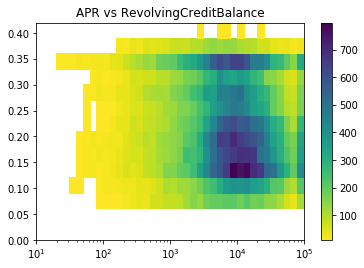

In [66]:
xstep = 0.1
binsx = 10**np.arange(1,np.log10(100000)+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d(x = varsToScatter['RevolvingCreditBalanceTrans'].where(lambda x: x != 0, 0.1),y = varsToScatter['BorrowerAPR'],bins = [binsx, binsy], cmap = 'viridis_r', cmin = 10);
plt.xscale('log')
plt.colorbar()
plt.title('APR vs RevolvingCreditBalance')

Text(0.5, 1.0, 'APR vs DebtToIncomeRatio')

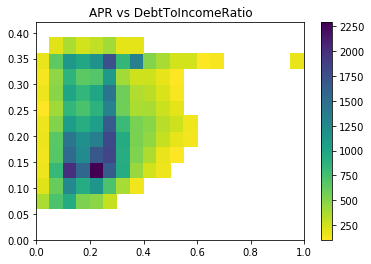

In [67]:
xstep = 0.05
binsx = np.arange(0,1+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d(x = varsToScatter['DebtToIncomeRatio'].where(lambda x: x != 0, 0.1),y = varsToScatter['BorrowerAPR'],bins = [binsx, binsy], cmap = 'viridis_r', cmin = 100);
plt.colorbar()
plt.title('APR vs DebtToIncomeRatio')

In general, I think that when the relationships are hard to hint with a scatter plot, a heatmap may be a better choice. In this case it can be seen that the correlation is not strong, however a slight negative trend can be appreciated and it's highlighted with darker colors. This gives the idea that the more revolving credit balance the better interest rate an individual may get. However this relation is quite weak.

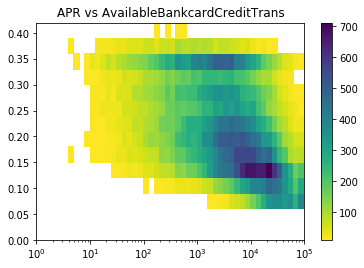

In [68]:
xstep = 0.1
binsx = 10**np.arange(0,np.log10(100000)+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d(x = varsToScatter['AvailableBankcardCreditTrans'].where(lambda x: x != 0, 0.1),y = varsToScatter['BorrowerAPR'],bins = [binsx, binsy], cmap = 'viridis_r', cmin = 10);
plt.colorbar()
plt.title('APR vs AvailableBankcardCreditTrans')
plt.xscale('log')

As the cross correlation table anticipated, the relation with Available bank card credit is stronger. A negative trend can be observed in darker colors in the image above.

Text(0.5, 1.0, 'APR vs DelinquenciesLast7YearsTrans')

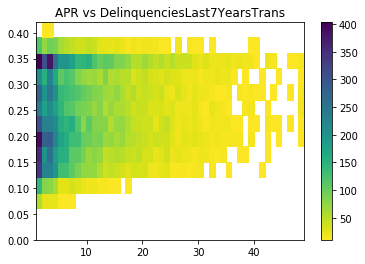

In [69]:
xstep = 1
binsx = np.arange(1,50,xstep)
ystep = 0.03
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d(data = varsToScatter, x = varsToScatter['DelinquenciesLast7YearsTrans'],y = 'BorrowerAPR',bins = [binsx, binsy], cmap = 'viridis_r', cmin = 10);
plt.colorbar()
plt.title('APR vs DelinquenciesLast7YearsTrans')

In the particular case of Delinquencies... the relation is weak. It seems that as described before, as the number of delinquencies increases, the lower range for the APR increases too. This seems logical but perhaps the relation is weaker than I anticipated

Text(0.5, 1.0, 'APR vs CreditScoreRangeUpper')

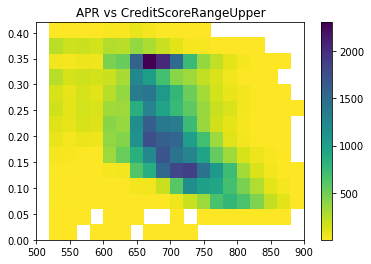

In [70]:
xstep = 20
binsx = np.arange(500,900+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d(data = varsToScatter, x = 'CreditScoreRangeUpper',y = 'BorrowerAPR',bins = [binsx, binsy], cmap = 'viridis_r', cmin = 0.5);
plt.colorbar()
plt.title('APR vs CreditScoreRangeUpper')

The plot above also show a negative correlation between APR and CreditScoreRangeUpper, same as with the scatterplot

Text(0.5, 1.0, 'APR vs LoanOriginalAmount')

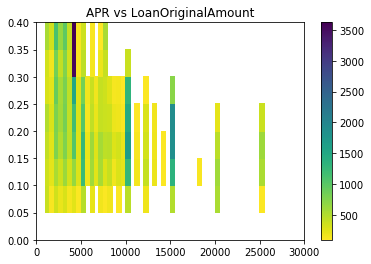

In [71]:
xstep = 500
binsx = np.arange(0,30000+xstep,xstep)
ystep = 0.05
binsy = np.arange(0,0.4+ystep,ystep)
plt.hist2d( x = loan_clean['LoanOriginalAmount'],y = varsToScatter['BorrowerAPR'],bins = [binsx, binsy], cmap = 'viridis_r', cmin = 100);
plt.colorbar()
plt.title('APR vs LoanOriginalAmount')

Lastly, the graph above shows that loans where the original amount is smaller are also given to risky individuals and so the APR extends across the whole range available. However as the requested amount for the loan increases it seems that these loans are only given to safer individuals and so the APR decreases. This is therefore a negative correlation but it will be better explained when adding multivariate plots as credit rating I think plays a role here.

Let's now look at bivariate relationships between one quantitative and one qualitative variables. Let's begin analysing our two variables of interest, that is LoanStatus and BorrowerAPR. Using a bar plot will give us an idea on mean values and confidence intervals for each of LoanStatus' categories.

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

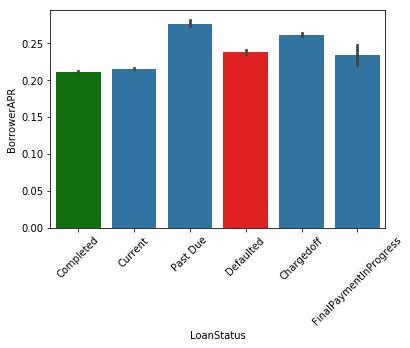

In [72]:
sb.barplot(data=loan_clean,x='LoanStatus', y='BorrowerAPR',palette=['green',basecolor,basecolor,'red',basecolor,basecolor,basecolor])
plt.xticks(rotation=45)

Based on the plot above it seems clear that Defaulted loans are on average assigned a higher APR than loans that are repaid with no issues. Also confidence intervals plot, seems to suggest that this difference is statistically significant. A point plot will give us a similar idea but making a zoom into the range of interest

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

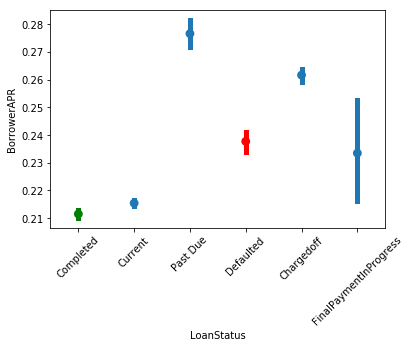

In [73]:
sb.pointplot(data=loan_clean,x='LoanStatus', y='BorrowerAPR',color=basecolor,errwidth=5,ci=99,join=False,palette=['green',basecolor,basecolor,'red',basecolor,basecolor,basecolor])
plt.xticks(rotation=45)

Another categorical feature that may be of interest *IsBorrowerHomeowner* will give us an idea on whether people that own a home get better APR rates than non-owner counterparts. In principle I'm inclined to think that they do as the bank would have a worthy asset to take if the borrower struggles to make payments.

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1]), <a list of 2 Text xticklabel objects>)

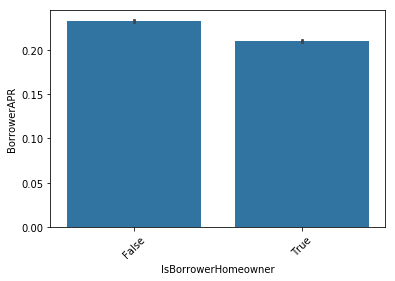

In [74]:
sb.barplot(data=loan_clean,x='IsBorrowerHomeowner', y='BorrowerAPR',color=basecolor)
plt.xticks(rotation=45)

It can be observed that my intutition was right and non-homeowners get worse rates than homeowners. However considering each group separately, which group has higher rates of default. In principle one would assume nonhomeowner would as they have worse APRs

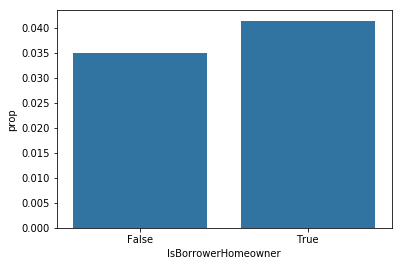

In [75]:
df = loan_clean.groupby(['IsBorrowerHomeowner','LoanStatus']).count().CreditGrade
df = df.unstack()
df['total'] = df.sum(axis=1)
df = df[['Defaulted','total']]
df['prop'] = df['Defaulted']/df['total']
df = df.reset_index()
sb.barplot(data=df, x='IsBorrowerHomeowner',y='prop',color=basecolor)

Surprisingly, the plot above shows that the ratio of people defaulting on their loans is higher among homeowners... So the fact that they get a better APR may be based only on the fact that the bank can always resort to their homes.     

Now, let's see the relationship between BorrowerAPR and the other two categorical variables

C:\Users\alero\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


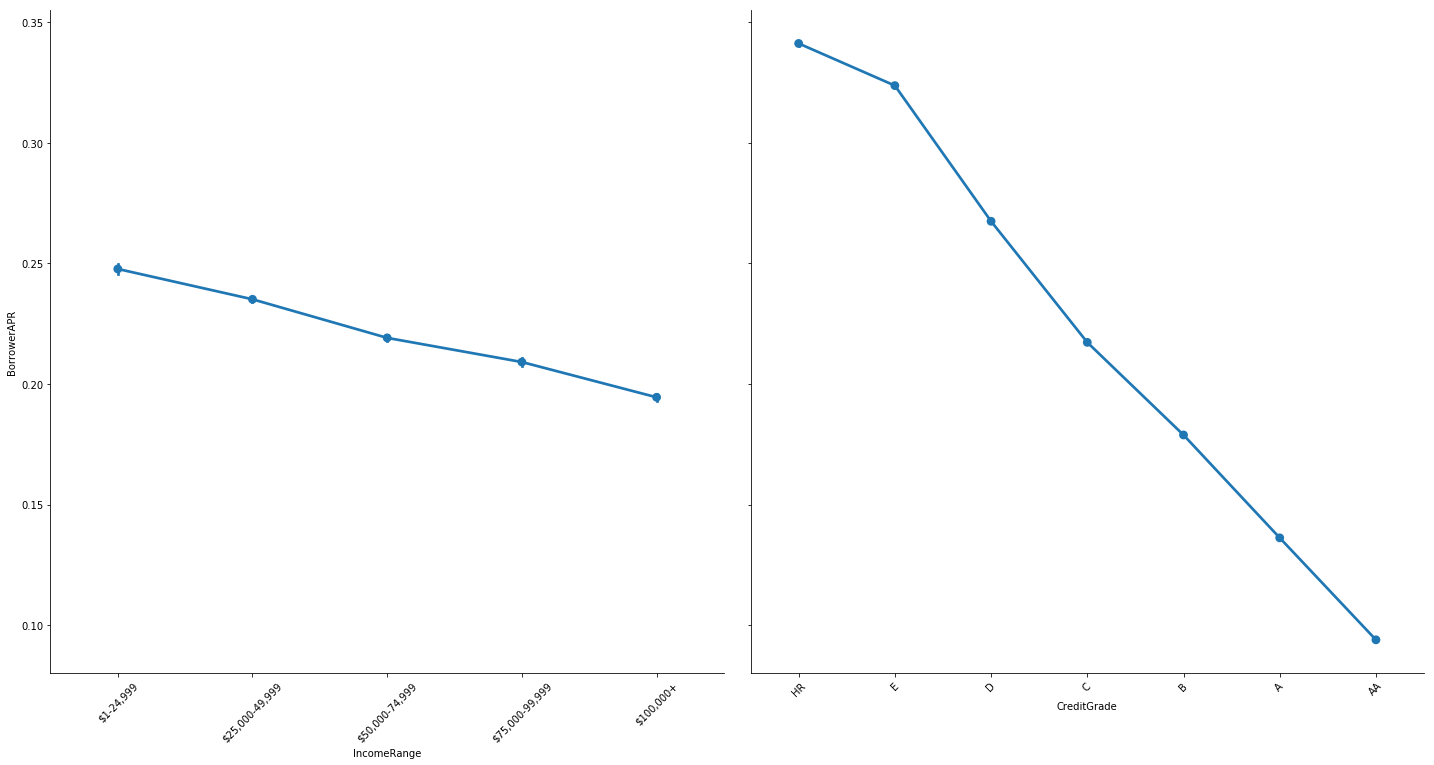

In [76]:
g = sb.PairGrid(data=loan_clean,x_vars=['IncomeRange','CreditGrade'], y_vars='BorrowerAPR',size=10)
g.map(sb.pointplot,color=basecolor)
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

It's clear from the plot above that both income and Credit Grade are negatively and linearly correlated with borrower APR. This also seems reasonable. The more someone earn the better credit grade they would normally have and the easier it's for them to repay their loans. So there is no surprise here.   

The next two plots represent the same variables using different styles. The idea is to find out whether different styles may convey different ideas. For the plots below we will be analysing relationships between the categorical variable of interest, that is LoanStatus, and the numerical features described before in this document. First, we will look at a barplot, then at a point plot. Please note that within LoanStatus, two categories will be highlighted. These correspond to completed with no issues in green and defaulted in red.

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


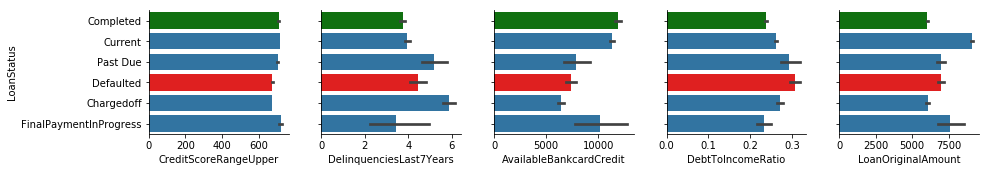

In [77]:
g=sb.PairGrid(data=loan_clean, x_vars=['CreditScoreRangeUpper', 'DelinquenciesLast7Years', 'AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount'], y_vars=['LoanStatus'])
g.map(sb.barplot,palette=['green',basecolor,basecolor,'red',basecolor,basecolor,basecolor])

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


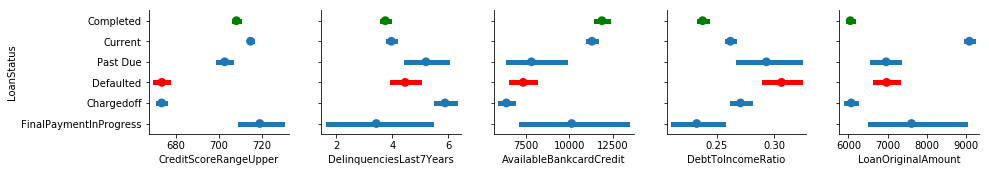

In [78]:
g=sb.PairGrid(data=loan_clean, x_vars=['CreditScoreRangeUpper', 'DelinquenciesLast7Years', 'AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount'], y_vars=['LoanStatus'])
g.map(sb.pointplot,palette=['green',basecolor,basecolor,'red',basecolor,basecolor,basecolor],errwidth=5,ci=99)

In my opinion the point plot is a better plot for drawing conclusions on data avaialable. Due to the fact that confidence intervals are more clearly visible we can make the following assertions
- Delinquencies over the last 7 years as well as loan original amount seem not to be clear indicators of loan default
- In contrast, credit score, available credit balance and debt to income ratio seem to be better features to determine whether an individual will default on their loans

Lastly, and to wrap up bivariate exploration, let's observe the relationship between our categorical variable of interest and the other categorical features. Let's start with the relation with IsBorrowerHomeowner

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

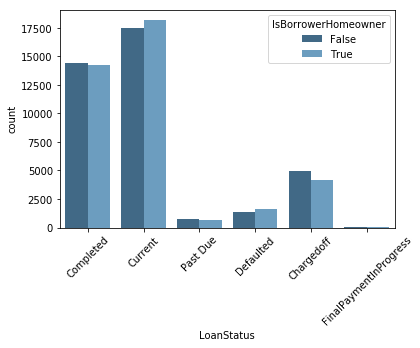

In [79]:
sb.countplot(data=loan_clean,x='LoanStatus', hue='IsBorrowerHomeowner',palette='Blues_d')
plt.xticks(rotation=45)

The graph above is hard to interpret. Since the number of loans for each category is so different the Y-scale is way too expanded to convey any information. Instead, let's transform our data and use ratios, this will make bars' height more equal

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

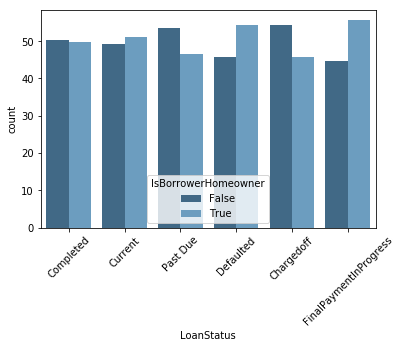

In [80]:
df = loan_clean[['IsBorrowerHomeowner','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','IsBorrowerHomeowner']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
sb.barplot(data=df,x='LoanStatus', y='count', hue='IsBorrowerHomeowner',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d')
plt.xticks(rotation=45)

The difference is noticeable and the plot is easier to interpret. Let's use this approach from now on. As for the data under analysis and as was discussed before, it seems strange that the proportion of people defaulting on their loans is much higher for those who own a home.

Let's see assess the relationship with borrower's income now.

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

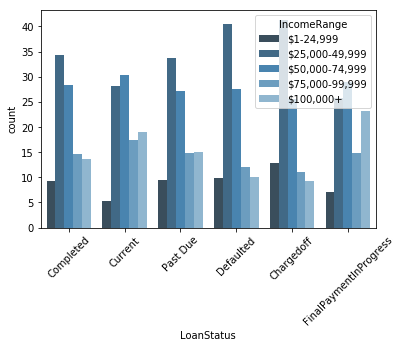

In [81]:
df = loan_clean[['IncomeRange','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','IncomeRange']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
df = df.drop(df[df['LoanStatus'] == 'Cancelled'].index,axis=0)
sb.barplot(data=df,x='LoanStatus', y='count', hue='IncomeRange',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d')
plt.xticks(rotation=45)

From the results above, it doesn't seem to be a great indicator of defaulting on a loan. It's true that for the default category there are proportially fewer people with higher incomes, but at least visually it's not that significant.

Lastly, let's look at credit grade vs loan status

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

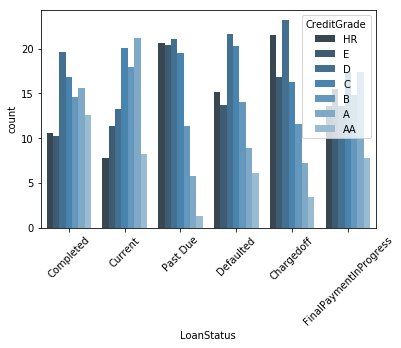

In [82]:
df = loan_clean[['CreditGrade','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','CreditGrade']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
df = df.drop(df[df['LoanStatus'] == 'Cancelled'].index,axis=0)
sb.barplot(data=df,x='LoanStatus', y='count',hue='CreditGrade',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d')
plt.xticks(rotation=45)

This seems to be a better indicator of an individual defaulting on a loan. It can be seen that worse credit rating proportions are higher for defaulted than they are for completed. Similarly, better ratings seem to be more prevalent for completed than for Defaulted

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> BorrowerAPR showed good correlation with some of the numerical features and some of the categorical. Perhaps the most interesting observation for this variable was that home owners have better APR rates even though the ratio of defaults appears to be higher for home owners. As anyone could have thought, interest rates were negatively correlated with credit rating and borrower's income. Some of the relations were less clear cut. For example the number of delinquencies seem to affect the lower end of borrowerAPR, but the correlation factor was far from high. AvailableBankcardCredit seem to have good correlation with BorrowerAPR, even though in order to observe it some data transformation had to be done on the data set.   
Overall, we conclude that BorrowerAPR depends on the following features: CreditScoreRangeUpper, AvailableBankcardCredit, LoanOriginalAmount, IsBorrowerHomeowner, IncomeRange and CreditGrade. Let's look at these in more detail in the next section

> LoanStatus was also plot against other features. Plots seemed to suggest that there is statistical evidence to suggest that whether an individual will default on a loan or not depends on features like: CreditScoreRangeUpper, DebtToIncomeRatio or AavailableBankcardCredit... As with APR before, Delinquencies are not a good predictor for LoanStatus. Also based on one of the plots above it seems that borrower's income is not a good predictor of LoanStatus either.   
Overall we conclude that LoanStatus depends on: CreditScoreRangeUpper, DebtToIncomeRatio, AvailableBankcardCredit, LoanOriginalAmount and IsBorrowerHomeowner.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Due to the high number of features to be analysed against our two variables of interest there is little room for any extra analysis, so feature-feature analysis has not been performed.

## Multivariate Exploration

> In the previous section we have analysed how our variables of interest relate to the other features. We concluded that some of them are of importance to describe the variables of interest and so these are the ones we will be focusing on now. The idea is to look at how several features impact joinly our variables of interest. Let's start with LoanStatus. This will attempt to answer the question that a financial institution may be asking, that is, how can I better predict which of my clients are more likely to default on their loans.

In order to anlyse numerical variables we will make use of heatmaps. The reason for this is that the number of points in our dataset is very large and heatmaps since to offer a cleaner option when compared to scatterplots. When using faceted heatmaps, as it will be the case when analysing two numerical variables against our variable of interest, it's important to normalize the results. In other words, the number of entries for loans that have been repaid successfully and defaulted loans is different. In order to have only one legend we need to normalize the plots with the following function

In [83]:
def heatmapNormalize(xvec,yvec,binsx,binsy,ltitles,suptitle, norm=True, cminThres=0.5,xlog=False,ylog=False):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(suptitle,fontsize=16)
    images = []
    len1 =len(xvec[0])
    len2 =len(xvec[1])
    ratio = []
    ratio.append( cminThres if len1/len2 < 1 else np.floor(len1/len2) + cminThres)
    ratio.append( cminThres if len2/len1 < 1 else np.floor(len2/len1) + cminThres)
    print (ratio)
    for j in range(2):
        # Generate data with a range that varies from one plot to the next.
        _,_,_,d = axs[j].hist2d(x=xvec[j],y=yvec[j],bins=[binsx,binsy], cmap = 'viridis_r',cmin=ratio[j])
        axs[j].set_title(ltitles[j])
        images.append(d)
        axs[j].label_outer()
        if xlog:
            axs[j].set_xscale('log')
        if ylog:
            axs[j].set_yscale('log')

    # Since both subplots may have different number of points, calculate ratios
    if norm:
        for image in images:
            arr = image.get_array()/image.get_array().sum()
            image.set_array(arr*100) # in percentage points

    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)
    fig.colorbar(images[1], ax=axs, orientation='vertical', fraction=.1)


In [84]:
loan_clean['LoanOriginalAmount'].describe()

count    77889.000000
mean      7491.793501
std       5780.185751
min       1000.000000
25%       3500.000000
50%       5000.000000
75%      10000.000000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

Let's first look at how AvailableBankcardCredit and DebtToIncomeRatio affect LoanStatus

[9.5, 0.5]


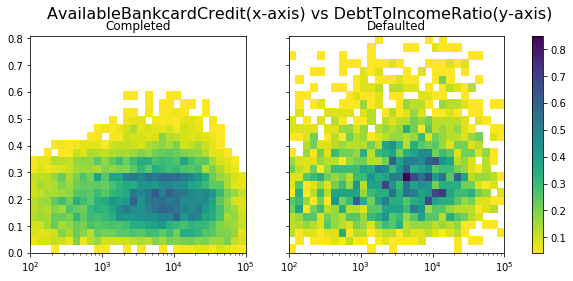

In [85]:
df_compl = loan_clean[loan_clean['LoanStatus']=='Completed' ].copy()
df_def = loan_clean[loan_clean['LoanStatus']=='Defaulted' ].copy()

xstep = 0.1
binsx = 10**np.arange(2,5+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.8+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs DebtToIncomeRatio(y-axis)'

heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['DebtToIncomeRatio'], df_def['DebtToIncomeRatio']],binsx,binsy,subplottitle,suptitle,cminThres=0.5,xlog=True)


From the heatmap above it seems clear that higer debt to income ratio is associated with higher probability of default. However it's hard to see a relation with available credit. Note that the heatmap above deals with credit in a logaritmic form. Let's switch back to linear in the x-axis to check whether a relationship is clearer.

[9.5, 0.5]


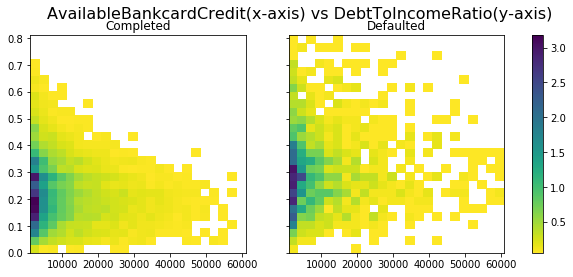

In [86]:
xstep = 2500
binsx = np.arange(1000,60000+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.8+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs DebtToIncomeRatio(y-axis)'
heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['DebtToIncomeRatio'], df_def['DebtToIncomeRatio']],binsx,binsy,subplottitle,suptitle,cminThres=0.5)

The graph above seems to suggest a linear relationship between card credit and debt to income ratio. If I was a bank and an individual with 40k avaliable bank card credit and a 0.6 debt to income ratio approached me, I would be quite reluctant to give this individual a loan. We could draw a line from point (1000,0.7) to point (60000,0.15) and all points above that could be regarded as very likely to default on their loans.

Let's check what happens for the other two numerical variables.

[11.5, 2.5]


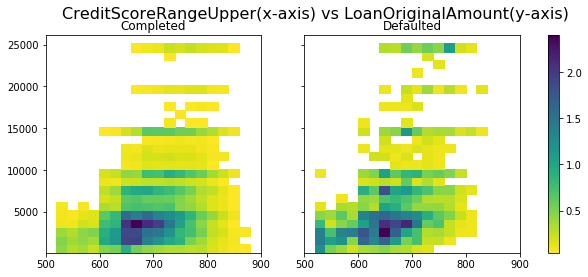

In [87]:
xstep = 20
binsx = np.arange(500,900+xstep,xstep)
ystep = 1000
binsy = np.arange(100,26000+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'CreditScoreRangeUpper(x-axis) vs LoanOriginalAmount(y-axis)'

heatmapNormalize([df_compl['CreditScoreRangeUpper'], df_def['CreditScoreRangeUpper']],[df_compl['LoanOriginalAmount'], df_def['LoanOriginalAmount']],binsx,binsy,subplottitle,suptitle,cminThres=2.5)

When analysing CreditScoreRangeUpper and LoanOriginalAmount it seems that the relationship is just not there... it's very hard to find meaninful differences between the two heatmaps given above... Overall it seems that higher credit score leads to more points in the "Completed" plot but it's risky to generalize given the above. It seems that these two variables will need to be looked together with the other two numerical features to assess whether they are relevant or not.

In order to do so, let's check what happens when analysing CreditScoreRangeUpper with AvailableBankcardCredit

[9.5, 0.5]


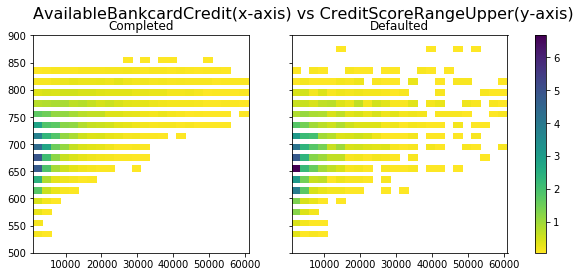

In [88]:
xstep = 2500
binsx = np.arange(1000,60000+xstep,xstep)
ystep = 10
binsy = np.arange(500,900+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs CreditScoreRangeUpper(y-axis)'
heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['CreditScoreRangeUpper'], df_def['CreditScoreRangeUpper']],binsx,binsy,subplottitle,suptitle,cminThres=0.5)

We see above that CreditScoreRangeUpper is not as useful as DebtToIncomeRatio when it comes to jointly assess LoanStatus. However, it's still possible to draw a linear relation between Bankcard credti and credit score from 500 up to 750. People repaying their loans seem to adjust to this relation pretty nicely, whereas people that default do not. In any case, it seems that the conclusions that can be drawn from CreditScoreRangeUpper are not as generic as the other two features.

If we were now, to look at loan original amount vs available bank card credit...

[10.5, 1.5]


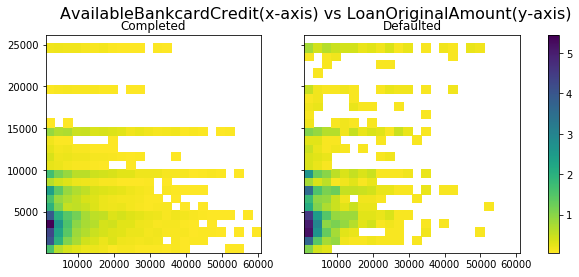

In [89]:
xstep = 2500
binsx = np.arange(1000,60000+xstep,xstep)
ystep = 1000
binsy = np.arange(100,26000+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs LoanOriginalAmount(y-axis)'
heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['LoanOriginalAmount'], df_def['LoanOriginalAmount']],binsx,binsy,subplottitle,suptitle,cminThres=1.5)

We can observe that it's really hard to draw any conclusions from the plot above... I'd be inclined to think that Loan amount has not much effect on explaining whether an individual will fail on their loan or not. Let's then focus on the other three.

[9.5, 0.5]


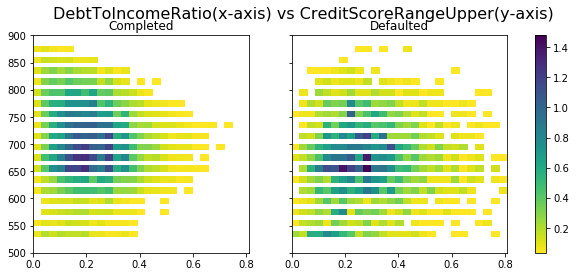

In [90]:
xstep = 0.03
binsx = np.arange(0,0.8+xstep,xstep)
ystep = 10
binsy = np.arange(500,900+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'DebtToIncomeRatio(x-axis) vs CreditScoreRangeUpper(y-axis)'
heatmapNormalize([df_compl['DebtToIncomeRatio'], df_def['DebtToIncomeRatio']],[df_compl['CreditScoreRangeUpper'], df_def['CreditScoreRangeUpper']],binsx,binsy,subplottitle,suptitle,cminThres=0.5)

Lastly, let's complete the numerical analysis by plotting the relation between DebtToIncomeRatio and credit score. Again the fact that credit score is present makes the picture less compelling. However a difference between the left and right plot can be observed.

Let's move on to anlayse the categorical variables.

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


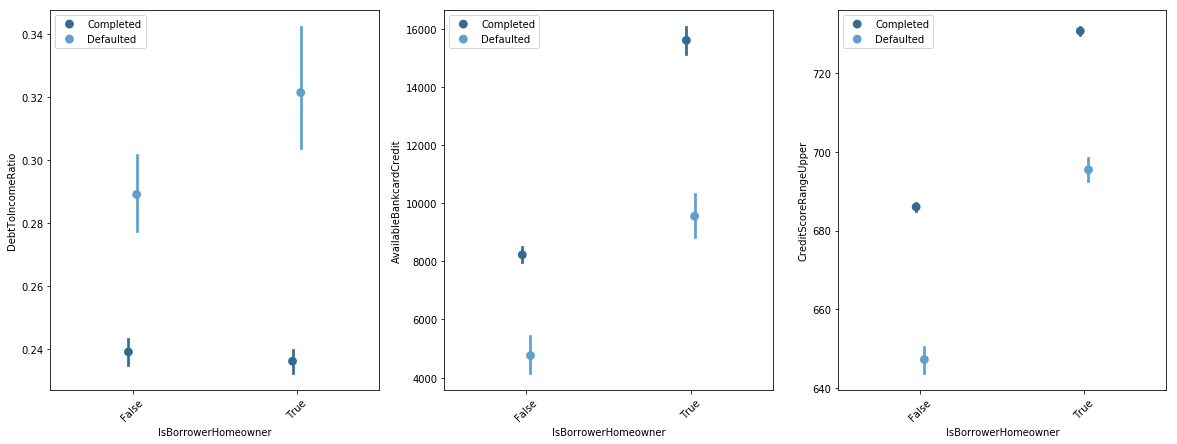

In [91]:
loan_clean_2 = loan_clean[ loan_clean['LoanStatus'].isin(['Completed','Defaulted']) ].copy()
numeric_list = ['DebtToIncomeRatio','AvailableBankcardCredit','CreditScoreRangeUpper']
plt.figure(figsize=(20,7))
for i,var in enumerate(numeric_list):
    plt.subplot(1,3,i+1)
    sb.pointplot(data=loan_clean_2, x='IsBorrowerHomeowner', y=var,hue='LoanStatus',palette='Blues_d',dodge=True,join=False)
    plt.xticks(rotation=45)
    plt.legend()

Being a home owner provides significant information to assess whether a person will default on their loans or not for variables AvailableBankcardCredit and CreditScoreRangeUpper. For DebtToIncomeRatio this difference is more subtle and only affects people that default on their loans not people that repaid entirely.

So to sum up, DebtToIncomeRatio and AvailableBankcardCredit are important to assess the probability that an individual will default on their loan or not. To a lesser degree CreditScoreRangeUpper also provides some information that will help determine LoanStatus prospects. It has been observed that LoanOriginalAmount is of no much use when combined with other features. From a lender perspective whether the individual owns a home or not it's also important and provides useful information as it can be seen in the last plot.

Let's now look at it from a borrower's point of view. Recall that the most important features that affect APR are the numericals: CreditScoreRangeUpper, AvailableBankcardCredit and LoanOriginalAmount. Also important to analyse the following categorical: IsBorrowerHomeowner, IncomeRange and CreditGrade

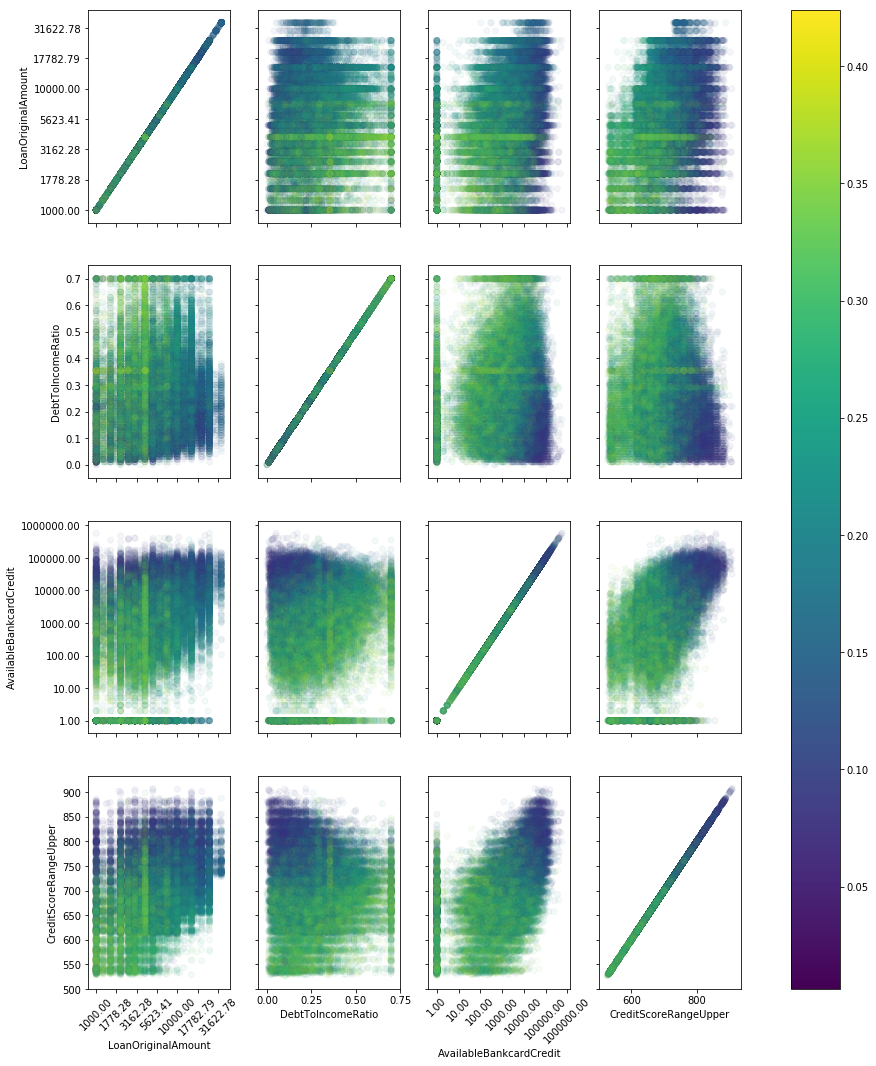

In [92]:
loan_clean_4 = loan_clean[['LoanOriginalAmount','DebtToIncomeRatio','AvailableBankcardCredit','CreditScoreRangeUpper']].copy()
loan_clean_4['LoanOriginalAmount'] = np.log10(loan_clean_4['LoanOriginalAmount'])#.where(lambda x: x <30000, 30000)
loan_clean_4['DebtToIncomeRatio'] = loan_clean_4['DebtToIncomeRatio'].where(lambda x: x <0.7, 0.7)
loan_clean_4['AvailableBankcardCredit'] = np.log10(loan_clean_4['AvailableBankcardCredit'].where(lambda x: x >0, 1))
randcr= 4 * np.random.randn(loan_clean_4.shape[0])
loan_clean_4['CreditScoreRangeUpper'] = loan_clean_4.CreditScoreRangeUpper + randcr
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(18, 18),squeeze=False,sharey='row',sharex='col')
ima = []
for i,col1 in enumerate(loan_clean_4.columns):
    for j,col2 in enumerate(loan_clean_4.columns):
        ima.append(axs[i][j].scatter(loan_clean_4[col2],loan_clean_4[col1],alpha=0.05, c = loan_clean['BorrowerAPR'] ))
        if j == 0:
            axs[i][j].set_ylabel(col1)
            mytic = []
            if i == 0:
                mytic = np.arange(3,4.6,0.25)
            if i == 2:
                mytic = np.arange(0,6.2,1)
            if len(mytic) > 0:
                axs[i][j].set_yticks(mytic)
                axs[i][j].set_yticklabels(["{0:.2f}".format(10**i) for i in mytic]) 
        if i == 3:
            axs[i][j].set_xlabel(col2)
            mytic = []
            if j == 0:
                mytic = np.arange(3,4.6,0.25)
            if j == 2:
                mytic = np.arange(0,6.2,1)
            if len(mytic) > 0:
                axs[i][j].set_xticks(mytic)
                axs[i][j].set_xticklabels(["{0:.2f}".format(10**i) for i in mytic],rotation=45) 

norm = colors.Normalize(vmin= loan_clean['BorrowerAPR'].min(), vmax= loan_clean['BorrowerAPR'].max())
for im in ima:
    im.set_norm(norm)
color_bar = fig.colorbar(ima[1], ax=axs, orientation='vertical', fraction=.3)
color_bar.set_alpha(1)
color_bar.draw_all()

C:\Users\alero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Not Home Owner')

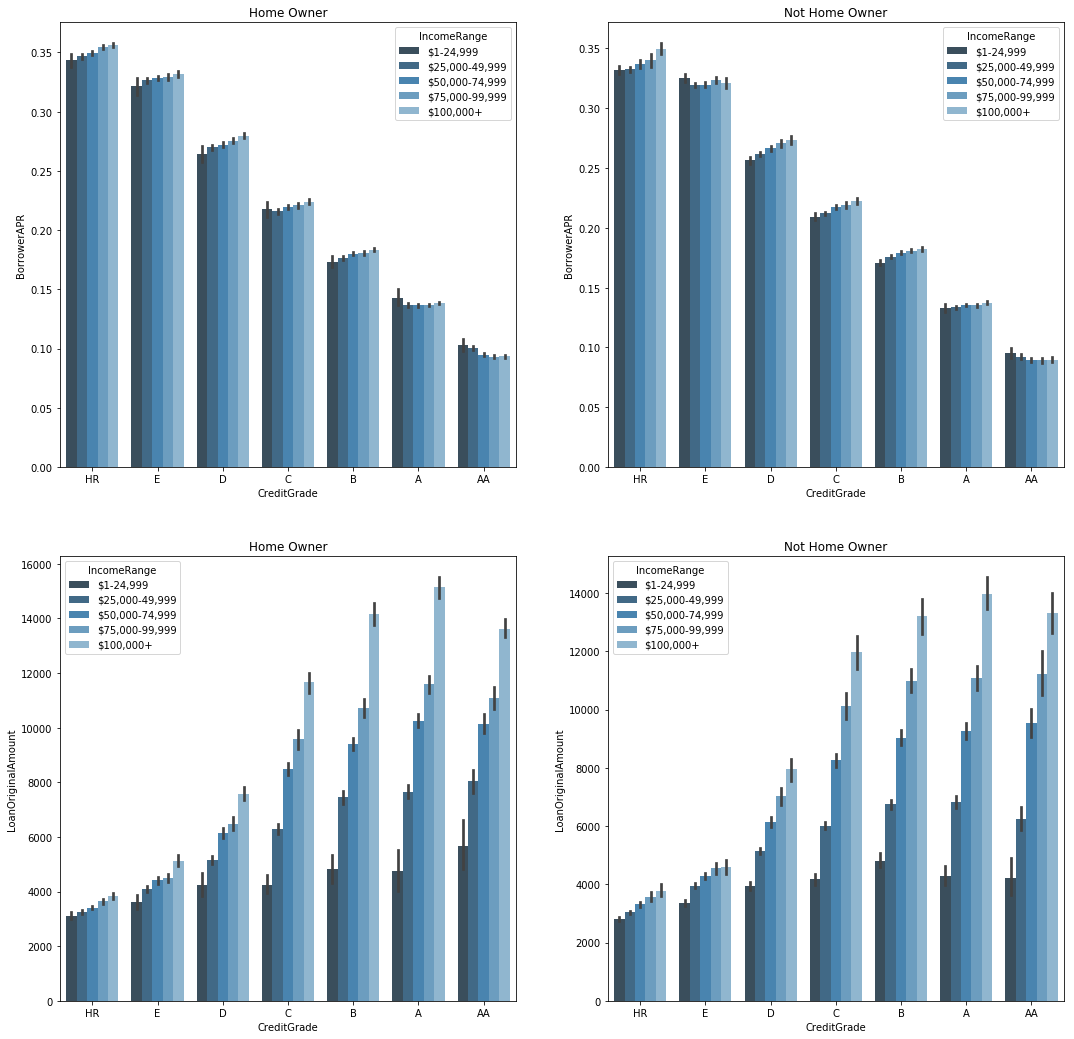

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 18),squeeze=False,sharey='row',sharex='col')
plt.subplot(2,2,1)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==True],x='CreditGrade',y='BorrowerAPR',hue='IncomeRange',palette='Blues_d')
plt.title('Home Owner')
plt.subplot(2,2,2)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==False],x='CreditGrade',y='BorrowerAPR',hue='IncomeRange',palette='Blues_d')
plt.title('Not Home Owner')
plt.subplot(2,2,3)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==True],x='CreditGrade',y='LoanOriginalAmount',hue='IncomeRange',palette='Blues_d')
plt.title('Home Owner')
plt.subplot(2,2,4)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==False],x='CreditGrade',y='LoanOriginalAmount',hue='IncomeRange',palette='Blues_d')
plt.title('Not Home Owner')

The graph above included originally the two left plots that compared APR vs credit grade, income range and whether the borrower was a homeowner or not. However it gave me strange results. As it can be seen in both plots on the left, APR increases with income salary. This seem counter intuitive to me and so I plot the two figures on the right. There one explanation to this paradox can be found. With a higher salary generally comes a higher loan. A higher loan will involve more risk from a financial institution point of view and so they give a higher APR. 

From these results it can be seen how complicated is to draw conclusions when the number of features increases. Overall I'd say that the better credit grade and loan amount the better APR that can be obtained.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Having carried out a multivariate analysis on CreditStatus, it seems clear that there are some numerical values that play well together and some that don't. If I was a finanacial institution it seems very clear that I would enquiry my client about their available bank card credit and debt to income ratio. The combination of these two may be key to cast some uncertainty over the potential customer. CreditScoreRangeUpper is another numerical value that adds more information to a lesser extent than the previous two. However, the original loan amount does not add any useful information when combined with any of the other three numerical variables.    
As far as the categorical features are concern, it seems also clear that whether the borrower is homeowner or not gives some information on the probability that they will default on the loan. Specifically, when analysed with available bank card credit and credit score range upper, feature IsBorrowerHomeowner could be used to forecast whether an individual may default on their loans

> Multivariate analysis on the other variable of interest has been carried out a bit differently. In this case, since the variable of interest is numerical as opposed to categorical scatter plots using three features were used. The dark blue area signals the areas where a borrower would like to be. These are the areas that offer better interest rates. Intestingly, variable DebtToIncomeRatio didn't seem to offer any added value. The other three numerical variables analysed can be used jointly to look at how a prospective borrower can bring the APR down to his/her own benefit. This analysis on numerical variables didn't surprise me much and conclusiones "made sense". However, when analysing the effect of categorical features on APR I had to stop for a while and think. Originally I had only plot Credit grade and salary range vs APR. I found out that APR increased with increasing salaries. To me this looked a bit strange. Then I thought that this may be due to some other parameter playing a factor here. Indeed, when plotted the same features against loan original amount it seemed cleared that the higher APR is likely to be caused by higher borrowing amount from higher income individuals.

### Were there any interesting or surprising interactions between features?

> Again, due to the high number of features to be analysed against our two variables of interest there is little room for any extra analysis, so feature-feature analysis has not been performed.